#**Data Description**
The Dataset have 3 Folders(train,test and val) which contain two subfolders for each category(Pneumonia and Normal). There are 5,863 X-Ray images and 2 Category i.e. Pneumonia and Normal.


In [0]:
import pandas as pd
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Randomly Checking a X-Ray image and trying to make its array using numpy np.array before we do for all the images.

uint8
(1317, 1857)


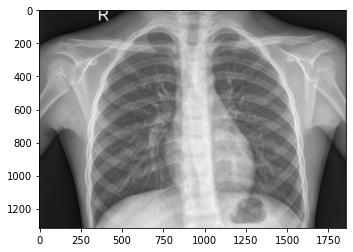

In [0]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image = cv2.imread('/content/drive/My Drive/X-Ray/chest_xray/test/NORMAL/IM-0001-0001.jpeg',0) #0 for grayscale vector array

# summarize shape of the pixel array
print(image.dtype)
print(image.shape)

# display the array of pixels as an image
pyplot.imshow(image, cmap='gray')
pyplot.show()

Reading Images from the google drive folder which we mounted on google colab and converting them into array.

In [0]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [0]:
val = get_data('/content/drive/My Drive/X-Ray/chest_xray/val')

In [0]:
test = get_data('/content/drive/My Drive/X-Ray/chest_xray/test')

In [0]:
train = get_data('/content/drive/My Drive/X-Ray/chest_xray/train')

#Data Visualisation

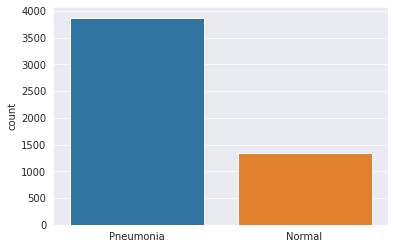

In [0]:
a = []
for i in train:
    if(i[1] == 0):
        a.append("Pneumonia")
    else:
        a.append("Normal")
sns.set_style('darkgrid')
sns.countplot(a)

From this we can say that train data is imbalanced so later we will use Data Augmentation to increase the examples of training data.

Previewing Both classes Image

Text(0.5, 1.0, 'NORMAL')

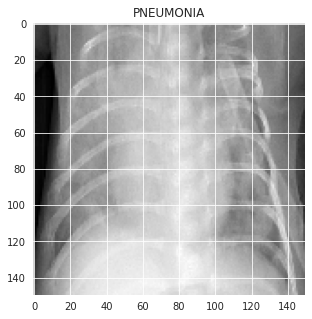

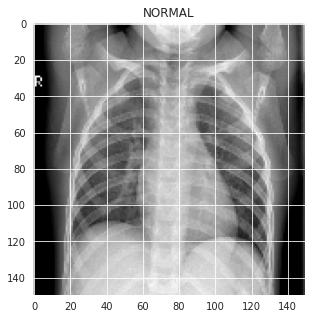

In [0]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

#Splitting x and y of train, test and val

In [0]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

In [0]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [0]:
x_val = []
y_val = []

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

#Performing Grayscale Normalization

In [0]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

#Resizing Data

In [0]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [0]:
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('*'*35)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)
print('*'*35)
print('Shape of x_val:', x_val.shape)
print('Shape of y_val:', y_val.shape)

Shape of x_train: (5216, 150, 150, 1)
Shape of y_train: (5216,)
***********************************
Shape of x_test: (624, 150, 150, 1)
Shape of y_test: (624,)
***********************************
Shape of x_val: (16, 150, 150, 1)
Shape of y_val: (16,)


#Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip = False, 
        vertical_flip=False) 


In [0]:
datagen.fit(x_train)

For Data Augmentation we have used:

* Randomly rotate some training images by 30 degrees
* Randomly Zoom by 20% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height 

Once our model is ready, we fit the training dataset.

#Training Model

In [0]:
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, MaxPool2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

* **1 Dense Neural Network** 

In [80]:
# First model is a dense neural network model with 5 layers
model_1 = Sequential()
model_1.add(Dense(200, activation = "relu", input_shape = (150,150,1,)))
model_1.add(Dense(100, activation = "relu"))
model_1.add(Dense(60, activation = "relu"))
model_1.add(Dense(30, activation = "relu"))
model_1.add(Flatten())
model_1.add(Dense(10, activation = "softmax"))

# Define the optimizer and compile the model
optimizer = optimizers.SGD(lr=0.03, clipnorm=5.)
model_1.compile(optimizer= optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

print (model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 150, 150, 200)     400       
_________________________________________________________________
dense_3 (Dense)              (None, 150, 150, 100)     20100     
_________________________________________________________________
dense_4 (Dense)              (None, 150, 150, 60)      6060      
_________________________________________________________________
dense_5 (Dense)              (None, 150, 150, 30)      1830      
_________________________________________________________________
flatten_1 (Flatten)          (None, 675000)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                6750010   
Total params: 6,778,400
Trainable params: 6,778,400
Non-trainable params: 0
____________________________________________

In [83]:
history = model_1.fit_generator(datagen.flow(x_train,y_train), steps_per_epoch= 5217//16, epochs=10, validation_data=(x_val,y_val), validation_steps=17//16)

Epoch 1/10
326/326 [==============================] - 1186s 4s/step - loss: 1.1715 - accuracy: 0.7299 - val_loss: 1.1928 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 1191s 4s/step - loss: 0.7371 - accuracy: 0.7429 - val_loss: 0.9879 - val_accuracy: 0.5000
Epoch 3/10
326/326 [==============================] - 1193s 4s/step - loss: 0.6590 - accuracy: 0.7429 - val_loss: 0.9289 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 1191s 4s/step - loss: 0.6295 - accuracy: 0.7429 - val_loss: 0.8934 - val_accuracy: 0.5000
Epoch 5/10
326/326 [==============================] - 1189s 4s/step - loss: 0.6143 - accuracy: 0.7429 - val_loss: 0.8875 - val_accuracy: 0.5000
Epoch 6/10
326/326 [==============================] - 1193s 4s/step - loss: 0.6053 - accuracy: 0.7429 - val_loss: 0.8664 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 1193s 4s/step - loss: 0.5993 - accuracy: 0.7429 - val_loss: 0.8685 - val_accuracy:

In [84]:
print("Loss of the model is - " , model_1.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model_1.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 22s 1s/step - loss: 0.7339 - accuracy: 0.6250
Loss of the model is -  73.39205145835876 %
20/20 [==============================] - 22s 1s/step - loss: 0.7339 - accuracy: 0.6250
Accuracy of the model is -  62.5 %


**Analysis of Model**

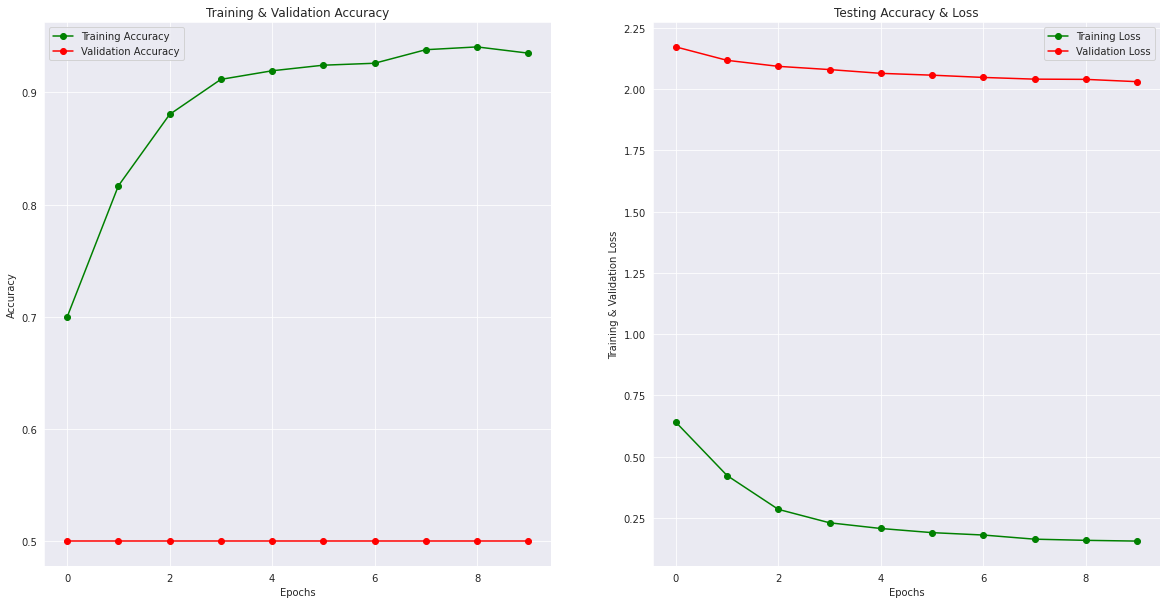

In [0]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [0]:
predictions = model_1.predict_classes(x_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* **2 Convolutional Neural Network**

In [21]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)       7

In [87]:
history1 = model.fit_generator(datagen.flow(x_train,y_train), steps_per_epoch= 5217//16, epochs=10, validation_data=(x_val,y_val), validation_steps=17//16)

Epoch 1/10
326/326 [==============================] - 438s 1s/step - loss: 0.1323 - accuracy: 0.9502 - val_loss: 0.2727 - val_accuracy: 0.8750
Epoch 2/10
326/326 [==============================] - 440s 1s/step - loss: 0.1268 - accuracy: 0.9540 - val_loss: 0.4832 - val_accuracy: 0.7500
Epoch 3/10
326/326 [==============================] - 445s 1s/step - loss: 0.1178 - accuracy: 0.9553 - val_loss: 0.6129 - val_accuracy: 0.8125
Epoch 4/10
326/326 [==============================] - 448s 1s/step - loss: 0.1203 - accuracy: 0.9523 - val_loss: 0.3620 - val_accuracy: 0.8125
Epoch 5/10
326/326 [==============================] - 438s 1s/step - loss: 0.1037 - accuracy: 0.9606 - val_loss: 0.4777 - val_accuracy: 0.8125
Epoch 6/10
326/326 [==============================] - 437s 1s/step - loss: 0.1014 - accuracy: 0.9611 - val_loss: 0.3637 - val_accuracy: 0.8750
Epoch 7/10
326/326 [==============================] - 439s 1s/step - loss: 0.0914 - accuracy: 0.9647 - val_loss: 0.5150 - val_accuracy: 0.8125

In [88]:
print("Model Loss - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Model Accuracy - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 7s 336ms/step - loss: 0.2180 - accuracy: 0.9135
Model Loss -  21.801576018333435 %
20/20 [==============================] - 7s 343ms/step - loss: 0.2180 - accuracy: 0.9135
Model Accuracy -  91.34615659713745 %


In [0]:
y_pred = model.predict_classes(x_test)

In [90]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.89      0.87      0.88       234

           accuracy                           0.91       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



**Plotting Confusion, Precision and Recall Matrix**

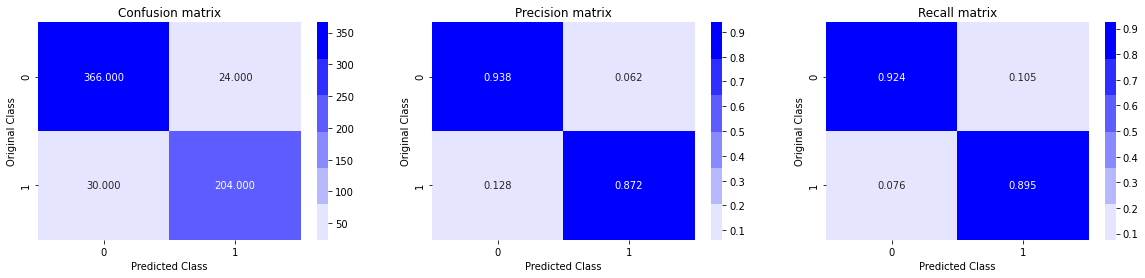

In [91]:
A = confusion_matrix(y_test,y_pred) #Confusion Matrix

B = (((A.T)/(A.sum(axis=1))).T) #Precision Matrix

C = (A/A.sum(axis=0)) #Recall Matrix

plt.figure(figsize=(20,4))

labels= [0,1]
cmap= sns.light_palette('blue')

#Confusion Matrix
plt.subplot(1,3,1)
sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")

#Precision Matrix
plt.subplot(1,3,2)
sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Precision matrix")
  
#Recall Marrix
plt.subplot(1,3,3)
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Recall matrix")

plt.show()

**Analysis of Model**

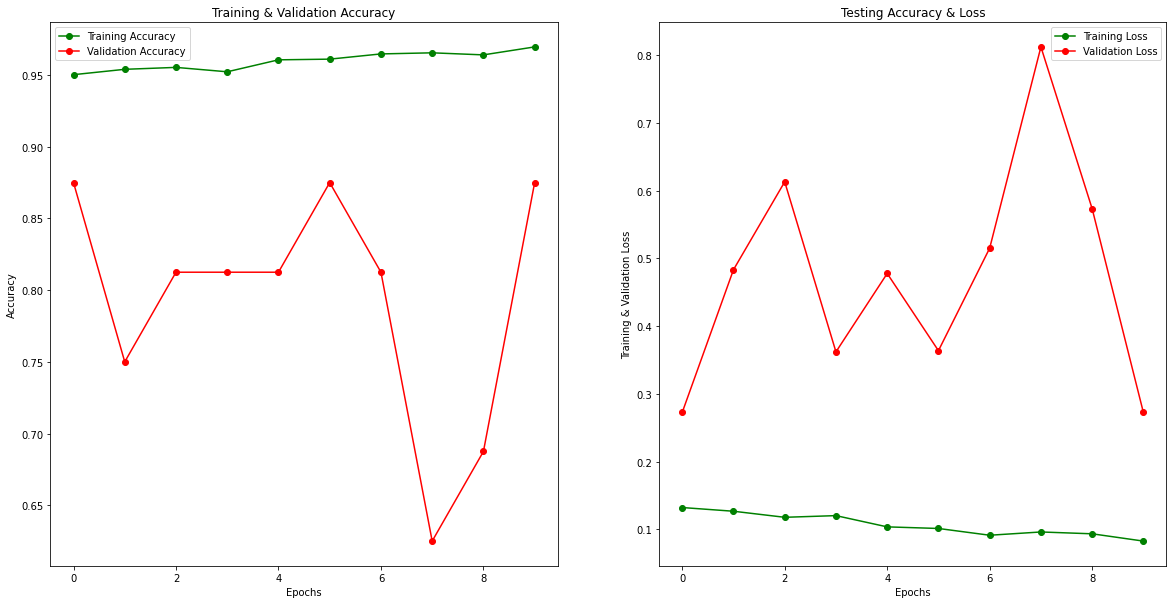

In [93]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()